# A1 That's What I LIKE

In [1]:
#import necessary library
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown
import time
import pandas as pd
import math
import torch.nn.functional as F

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath


## 1. Load data

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/maliboochuchu/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
#1. tokenization
corpus = brown.sents(categories=['news'])

In [4]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) 

In [5]:
#there are 14394 words in the vocabs
len(vocabs)

14394

In [6]:
#mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
index2word = {v:k for k, v in word2index.items()}

In [7]:
#add <UNK> as last index in the vocabs
vocabs.append('<UNK>')
word2index['<UNK>'] = 14394

## 2. Co-occurence Matrix X

for glove model

In [8]:
from collections import Counter
X_i = Counter(flatten(corpus))

In [9]:
skip_grams = []

for doc in corpus:
    for i in range(2, len(doc)-2):
        center = doc[i]
        outside = [doc[i-2],doc[i-1], doc[i+1],doc[i-2]]
        for each_out in outside:
            skip_grams.append((center, each_out))

In [10]:
X_ik_skipgrams = Counter(skip_grams)

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

In [11]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        #if not exist, then set to 1 "laplace smoothing"
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [12]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

In [13]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    skip_grams = []

    # loop each word sequence
    for sent in word_sequence:
        for i in range(window_size, len(sent) - window_size):
            target = word2index[sent[i]]
            context = [
                word2index[sent[j]]
                for j in range(i - window_size, i + window_size + 1) if j != i
            ]

            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target word
        random_labels.append([skip_grams[i][1]])  # context word

    return np.array(random_inputs), np.array(random_labels)

In [14]:
#random batch for glove model
def random_batch_glove(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] 
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

## Negative Sampling

In [15]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
# num_total_words

In [16]:
unigram_table = []
z = 0.001
for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
# Counter(unigram_table)

## 3. Model

### without negative sampling

In [17]:
#there are 14394 words in vocabs
len(vocabs)
embedding = nn.Embedding(14394, 2)

In [18]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss

In [19]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)

### with negative sampling

In [20]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [21]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

    #predict function
    def predict(self, A, B, C):
        # Given three words (A, B, C), return their embeddings

        A_idx = torch.tensor([word2index[A]])  # Convert words to indices
        B_idx = torch.tensor([word2index[B]])
        C_idx = torch.tensor([word2index[C]])

        A_embedding = self.embedding_center(A_idx)
        B_embedding = self.embedding_center(B_idx)
        C_embedding = self.embedding_center(C_idx)
        
        return A_embedding, B_embedding, C_embedding

### Glove

In [22]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.embedding_center(center) #(batch_size, 1, emb_size)
        outside_embeds = self.embedding_outside(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

    def predict(self, A, B, C):
        # Given three words (A, B, C), return their embeddings

        A_idx = torch.tensor([word2index[A]])  # Convert words to indices
        B_idx = torch.tensor([word2index[B]])
        C_idx = torch.tensor([word2index[C]])

        A_embedding = self.center_embedding(A_idx)
        B_embedding = self.center_embedding(B_idx)
        C_embedding = self.center_embedding(C_idx)
        
        return A_embedding, B_embedding, C_embedding

## 4. Training

In [23]:
batch_size = 2
emb_size   = 2
#skipgram
model1      = Skipgram(voc_size, emb_size)
#skipgram negative
model2      = SkipgramNeg(voc_size, emb_size)
#glove
model3      = Glove(voc_size, emb_size)
#use Adam as optimizer and use crossentropyloss
optimizer   = optim.Adam(model1.parameters(), lr=0.001)
optimizer   = optim.Adam(model2.parameters(), lr=0.001)
optimizer   = optim.Adam(model3.parameters(), lr=0.001)
criterion   = nn.CrossEntropyLoss()

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
num_epochs = 1000

start1 = time.time()
print("Model: Skipgram")
for epoch in range(num_epochs):
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    #predict
    loss1 = model1(input_tensor, label_tensor, all_vocabs)
    #backprogate
    optimizer.zero_grad()
    loss1.backward()
    #update alpha
    optimizer.step()
    #print the loss
    end1 = time.time()
    epoch_mins1, epoch_secs1 = epoch_time(start1, end1)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss1:2.6f} ")
        
end1 = time.time()
epoch_mins1, epoch_secs1 = epoch_time(start1, end1)
print(f"time: {epoch_mins1}m {epoch_secs1}s")
print("-"*20)

start2 = time.time()
print("Model: Skipgram Negative Sampling")
for epoch in range(num_epochs):
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    #predict
    k=5
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss2 = model2(input_tensor, label_tensor, neg_samples)

    #backprogate
    optimizer.zero_grad()
    loss2.backward()
    #update alpha
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss2:2.6f} ")
end2 = time.time()
epoch_mins2, epoch_secs2 = epoch_time(start2, end2)
print(f"time: {epoch_mins2}m {epoch_secs2}s")
print("-"*20)

start3 = time.time()
print("Model: Glove")
for epoch in range(num_epochs):

    input_batch, target_batch, cooc_batch, weighting_batch = random_batch_glove(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss3 = model3(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss3.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss3:2.6f} ")
end3 = time.time()
epoch_mins3, epoch_secs3 = epoch_time(start3, end3)
print(f"time: {epoch_mins3}m {epoch_secs3}s")
print("-"*20)


Model: Skipgram
Epoch    100 | Loss: 9.710272 
Epoch    200 | Loss: 10.725626 
Epoch    300 | Loss: 9.297529 
Epoch    400 | Loss: 9.823920 
Epoch    500 | Loss: 9.447436 
Epoch    600 | Loss: 11.885914 
Epoch    700 | Loss: 9.443340 
Epoch    800 | Loss: 11.999986 
Epoch    900 | Loss: 11.348657 
Epoch   1000 | Loss: 9.559290 
time: 5m 41s
--------------------
Model: Skipgram Negative Sampling
Epoch    100 | Loss: 2.013004 
Epoch    200 | Loss: 0.423247 
Epoch    300 | Loss: 1.331743 
Epoch    400 | Loss: 0.956040 
Epoch    500 | Loss: 1.806186 
Epoch    600 | Loss: 0.705355 
Epoch    700 | Loss: 2.115144 
Epoch    800 | Loss: 3.940357 
Epoch    900 | Loss: 2.863113 
Epoch   1000 | Loss: 2.230449 
time: 5m 35s
--------------------
Model: Glove
Epoch    100 | Loss: 0.979863 
Epoch    200 | Loss: 0.558037 
Epoch    300 | Loss: 1.301593 
Epoch    400 | Loss: 4.180156 
Epoch    500 | Loss: 15.184868 
Epoch    600 | Loss: 0.497459 
Epoch    700 | Loss: 1.185103 
Epoch    800 | Loss: 5.5161

## Plotting from Loss 

In [26]:
def get_embed(model, word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    word = torch.LongTensor([word2index[word]])

    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

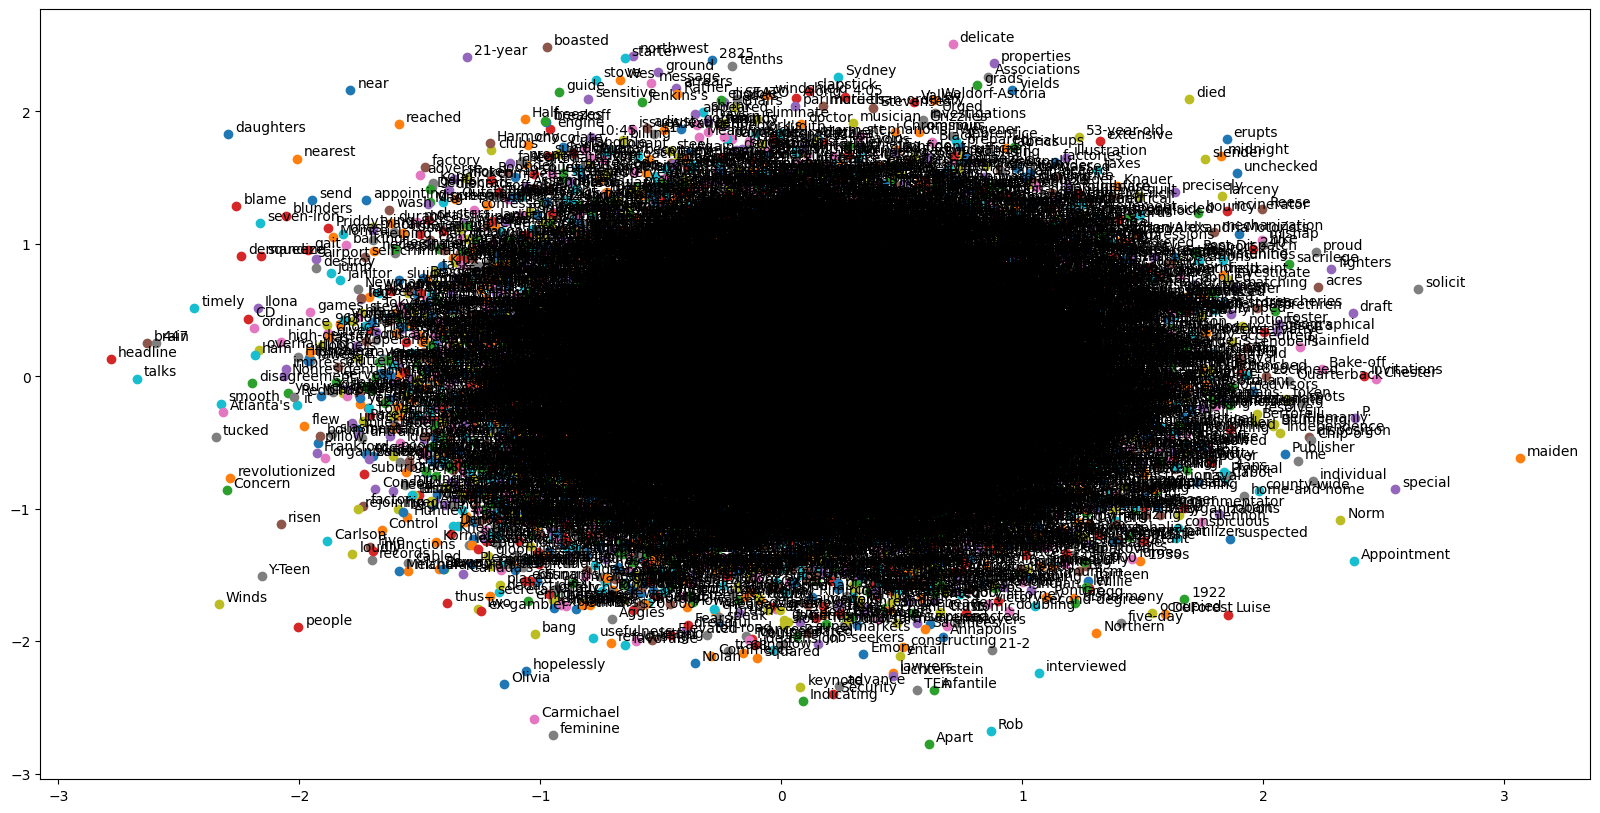

In [27]:
plt.figure(figsize=(20, 10))
for i, word in enumerate(vocabs):
    x, y = get_embed(model3,word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

- I choose model3 which is Glove model because Glove model gives me a lowest loss comparing to others model which are model1(Skipgram) and model2(Negative Sampling)

## Comparison and Analysis for all model

In [28]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    skip_grams = []

    # loop each word sequence
    for sent in word_sequence:
        for i in range(window_size, len(sent) - window_size):
            target = word2index[sent[i]]
            context = [
                word2index[sent[j]]
                for j in range(i - window_size, i + window_size + 1) if j != i
            ]

            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target word
        random_labels.append([skip_grams[i][1]])  # context word

    return np.array(random_inputs), np.array(random_labels)

In [29]:
def analogy_data(file_path):
    semantic = []
    syntactic = []
    section = None

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith(":"):
                if line == ": capital-common-countries":
                    section = "semantic"
                elif line == ": gram7-past-tense":
                    section = "syntactic"
                else:
                    section = None
                continue

            if section == "semantic":
                words = line.split()
                if len(words) == 4:
                    semantic.append(words)
            elif section == "syntactic":
                words = line.split()
                if len(words) == 4:
                    syntactic.append(words)

    return semantic, syntactic

In [30]:
file_path = "./word-test.v1.txt"
semantic_data, syntactic_data = analogy_data(file_path)

In [31]:
syntactic_data

[['dancing', 'danced', 'decreasing', 'decreased'],
 ['dancing', 'danced', 'describing', 'described'],
 ['dancing', 'danced', 'enhancing', 'enhanced'],
 ['dancing', 'danced', 'falling', 'fell'],
 ['dancing', 'danced', 'feeding', 'fed'],
 ['dancing', 'danced', 'flying', 'flew'],
 ['dancing', 'danced', 'generating', 'generated'],
 ['dancing', 'danced', 'going', 'went'],
 ['dancing', 'danced', 'hiding', 'hid'],
 ['dancing', 'danced', 'hitting', 'hit'],
 ['dancing', 'danced', 'implementing', 'implemented'],
 ['dancing', 'danced', 'increasing', 'increased'],
 ['dancing', 'danced', 'jumping', 'jumped'],
 ['dancing', 'danced', 'knowing', 'knew'],
 ['dancing', 'danced', 'listening', 'listened'],
 ['dancing', 'danced', 'looking', 'looked'],
 ['dancing', 'danced', 'moving', 'moved'],
 ['dancing', 'danced', 'paying', 'paid'],
 ['dancing', 'danced', 'playing', 'played'],
 ['dancing', 'danced', 'predicting', 'predicted'],
 ['dancing', 'danced', 'reading', 'read'],
 ['dancing', 'danced', 'running', '

In [32]:
semantic_data

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland'],
 ['Athens', 'Greece', 'Cairo', 'Egypt'],
 ['Athens', 'Greece', 'Canberra', 'Australia'],
 ['Athens', 'Greece', 'Hanoi', 'Vietnam'],
 ['Athens', 'Greece', 'Havana', 'Cuba'],
 ['Athens', 'Greece', 'Helsinki', 'Finland'],
 ['Athens', 'Greece', 'Islamabad', 'Pakistan'],
 ['Athens', 'Greece', 'Kabul', 'Afghanistan'],
 ['Athens', 'Greece', 'London', 'England'],
 ['Athens', 'Greece', 'Madrid', 'Spain'],
 ['Athens', 'Greece', 'Moscow', 'Russia'],
 ['Athens', 'Greece', 'Oslo', 'Norway'],
 ['Athens', 'Greece', 'Ottawa', 'Canada'],
 ['Athens', 'Greece', 'Paris', 'France'],
 ['Athens', 'Greece', 'Rome', 'Italy'],
 ['Athens', 'Greece', 'Stockholm', 'Sweden'],
 ['Athens', 'Greece', 'Tehran', 'Iran'],
 ['Athens', 'Greece', 'Tokyo', 'Japan'],
 ['Baghdad', 'Iraq', 'Bangkok', 'Thailand'

In [33]:
def predict_word(A, B, C, model, word2index, index2word):
    try:
        # Convert words to indices
        A_idx = torch.tensor([word2index[A]])
        B_idx = torch.tensor([word2index[B]])
        C_idx = torch.tensor([word2index[C]])

        # Get embeddings
        embedding_A = model.embedding_center(A_idx)
        embedding_B = model.embedding_center(B_idx)
        embedding_C = model.embedding_center(C_idx)
        
        # Calculate vector D (predicted)
        D = embedding_B - embedding_A + embedding_C

        # Normalize D vector
        D = F.normalize(D, p=2, dim=1)

        # Get all embeddings and normalize them
        all_embeddings = model.embedding_center.weight.detach()
        all_embeddings_norm = F.normalize(all_embeddings, p=2, dim=1)

        # Compute cosine similarity
        similarities = torch.matmul(all_embeddings_norm, D.T).squeeze()

        # Get the index of the word with the highest similarity
        best_idx = torch.argmax(similarities).item()

        # Return the predicted word
        return index2word[best_idx]
    except KeyError:
        # If a word is not in the vocabulary, return None
        return None

In [34]:
def evaluate_word_analogy(data, model, word2index, index2word):
    correct = 0
    total = len(data)

    for word1, word2, word3, word4 in data:  # A, B, C, D
        predicted_word = predict_word(word1, word2, word3, model, word2index, index2word)
        if predicted_word == word4:
            correct += 1
    # Compute accuracy
    accuracy = (correct / total) * 100
    return accuracy

In [35]:
def evaluate_gensim_word_analogy(data, model):
    correct = 0
    total = len(data)

    for word1, word2, word3, word4 in data:  # A, B, C, D
        # Convert words to lowercase
        word1, word2, word3, word4 = word1.lower(), word2.lower(), word3.lower(), word4.lower()
        # Skip analogy if any word is missing in the vocabulary
        if not all(word in model.key_to_index for word in [word1, word2, word3]):
            continue
        # Predict the missing word
        predicted_word = model.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0]

        # Compare the predicted word with the correct answer
        if predicted_word == word4:
            correct += 1

    # Compute accuracy
    accuracy = (correct / total) * 100
    return accuracy

### This is for GloVe(Gensim) file

In [36]:
glove_file = '/Users/maliboochuchu/Desktop/AIT/nlp/glove/glove.6B.100d.txt'
model4 = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [37]:
# Evaluate semantic accuracy
semantic_accuracy = evaluate_word_analogy(semantic_data, model1, word2index, index2word)
print(f"Semantic Accuracy Skipgram: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_word_analogy(semantic_data, model2, word2index, index2word)
print(f"Semantic Accuracy SkipgramNec: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_word_analogy(semantic_data, model3, word2index, index2word)
print(f"Semantic Accuracy Glove: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_gensim_word_analogy(semantic_data, model4)
print(f"Semantic Accuracy GloVe Gensim: {semantic_accuracy:.2f}%")

print("=="*20)
# Evaluate syntactic accuracy
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model1, word2index, index2word)
print(f"Syntactic Accuracy Skipgram: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model2, word2index, index2word)
print(f"Syntactic Accuracy SkipgramNec: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model3, word2index, index2word)
print(f"Syntactic Accuracy Glove: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_gensim_word_analogy(syntactic_data, model4)
print(f"Syntactic Accuracy GloVe Gensim: {syntactic_accuracy:.2f}%")

Semantic Accuracy Skipgram: 0.00%
Semantic Accuracy SkipgramNec: 0.00%
Semantic Accuracy Glove: 0.00%
Semantic Accuracy GloVe Gensim: 93.87%
Syntactic Accuracy Skipgram: 0.00%
Syntactic Accuracy SkipgramNec: 0.00%
Syntactic Accuracy Glove: 0.00%
Syntactic Accuracy GloVe Gensim: 55.45%


# Finding Word Correlation

In [38]:
# Load the wordsim dataset
file_path = './wordsim353_sim_rel/wordsim_similarity_goldstandard.txt'
wordsim_data = pd.read_csv(file_path, sep='\t', header=None, names=["word1", "word2", "Human(mean)"])

print(wordsim_data.head())

        word1  word2  Human(mean)
0       tiger    cat         7.35
1       tiger  tiger        10.00
2       plane    car         5.77
3       train    car         6.31
4  television  radio         6.77


In [39]:
def cosine_similarity(A, B):
    dot_product = np.dot(A.flatten(), B.flatten())
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [40]:
def compute_similarity(word1, word2, model, word2index):
    if word1 in word2index and word2 in word2index:
        # Get embeddings
        embedding1 = model.embedding_center(torch.tensor([word2index[word1]])).detach().numpy()
        embedding2 = model.embedding_center(torch.tensor([word2index[word2]])).detach().numpy()
        
        # Compute cosine similarity
        similarity = cosine_similarity(embedding1,embedding2)
        return similarity

In [41]:
def compute_similarity_gensim(word1, word2, model):
    if word1 in model.key_to_index and word2 in model.key_to_index:
        # Gensim similarity method
        similarity = model.similarity(word1, word2)
        return similarity

In [42]:
from scipy.stats import spearmanr

def evaluate_correlation(data, model, word2index=None, model_type="custom"):
    predicted_similarities = []
    human_similarities = []

    for _, row in data.iterrows():
        word1, word2, human_similarity = row["word1"], row["word2"], row["Human(mean)"]

        # Compute model-based similarity
        if model_type == "gensim":
            similarity = compute_similarity_gensim(word1, word2, model)
        else:
            similarity = compute_similarity(word1, word2, model, word2index)

        # Collect scores if similarity is valid
        if similarity is not None:
            predicted_similarities.append(similarity)
            human_similarities.append(human_similarity)

    correlation = spearmanr(predicted_similarities, human_similarities).correlation
    return correlation

### Correlation Output

In [43]:
correlation = evaluate_correlation(wordsim_data, model1, word2index, model_type="")
print(f"Correlation Skipgram Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, model2, word2index, model_type="")
print(f"Correlation Skipgram with negative sampling Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, model3, word2index, model_type="")
print(f"Correlation Glove Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, model4, word2index, model_type="gensim")
print(f"Correlation Glove(Gensim) Model : {correlation:.4f}")

Correlation Skipgram Model : -0.0100
Correlation Skipgram with negative sampling Model : -0.0562
Correlation Glove Model : -0.0735
Correlation Glove(Gensim) Model : 0.6019


# Inference

In [67]:
def search_similar(input_word, model, vocabs, word2index, top_n=10):
    word_similarities = {}
    try:
        input_embed = get_embed(model, input_word)
        if isinstance(input_embed, tuple):
            input_embed = np.array(input_embed)

        for word in vocabs:
            if word in word2index:  # Check if the word is in the vocabulary
                word_embed = get_embed(model, word)
                if isinstance(word_embed, tuple):
                    word_embed = np.array(word_embed)
                similarity = cosine_similarity(input_embed, word_embed)
                word_similarities[word] = similarity

        sorted_similarities = sorted(word_similarities.items(), key=lambda x: x[1], reverse=True)

        return sorted_similarities[:top_n] #Return top 10

    except KeyError:
        return "This word is not in the vocabulary. Please try another word."
    except Exception as e:
        return f"An error occurred: {str(e)}"

In [68]:
similar_words = search_similar("city", model4, vocabs, word2index, top_n=10)
print(similar_words)

An error occurred: 'KeyedVectors' object has no attribute 'embedding_center'


- firstly i want to choose model GloVe(Gensim) but the Keyvector has no attributes for word embedding. So, my conclusion i will choose Skipgram model which is model1. It has the least negative correlation among the four, indicating it may slightly outperform the others in aligning with others data.

In [69]:
similar_words = search_similar("city", model1, vocabs, word2index, top_n=10)
print(similar_words)

[('city', 1.0000000000000002), ('miffed', 0.9999999959822239), ('exported', 0.9999999897181086), ('Pharmical', 0.9999999758850833), ('pros', 0.9999998198338291), ("We're", 0.9999997653111015), ('double-crosser', 0.9999988472824045), ('reflected', 0.999998840416466), ('stewardess', 0.9999973764137201), ('severe', 0.9999968580799685)]


In [70]:
vocabs

['Johnston',
 'Innumerable',
 'candid',
 'Mill',
 'tidying',
 'Neil',
 'Bursts',
 'Wesley',
 'ruling',
 'Counties',
 'infield',
 'ticket',
 'wards',
 'Butlers',
 'Coronado',
 'contaminating',
 'blasted',
 'kidnaped',
 'bored',
 '$5,000',
 'Bregman',
 'even',
 'mechanisms',
 'agonizing',
 'quarter-century',
 'Bordeau',
 'all-American',
 'feminine',
 'implicit',
 'schools',
 'locale',
 'strengthen',
 'Wendells',
 'engine',
 'Germania',
 'guessing',
 'everybody',
 'solicit',
 'declare',
 'cuts',
 'unfortunately',
 'pledges',
 'positive',
 'rulers',
 'Strafaci',
 'wormy',
 '58',
 'Maynard',
 'grip',
 "I'd",
 'disputes',
 "Broglio's",
 'govern',
 'company',
 "Baylor's",
 'Giants',
 'envision',
 'imply',
 'stiff',
 'Australia',
 "W.'s",
 'gone',
 'appealing',
 'doubtless',
 'feel',
 'contendere',
 'Miss',
 'LaSalle',
 'Rollie',
 'automatic',
 'sea',
 'quickly',
 'states',
 'zinc',
 'widowed',
 'taffeta',
 'People',
 'technical',
 'began',
 'tendency',
 'sewer',
 'bad',
 'Pitcher',
 'irregula

In [73]:
print(word2index)

{'Johnston': 0, 'Innumerable': 1, 'candid': 2, 'Mill': 3, 'tidying': 4, 'Neil': 5, 'Bursts': 6, 'Wesley': 7, 'ruling': 8, 'Counties': 9, 'infield': 10, 'ticket': 11, 'wards': 12, 'Butlers': 13, 'Coronado': 14, 'contaminating': 15, 'blasted': 16, 'kidnaped': 17, 'bored': 18, '$5,000': 19, 'Bregman': 20, 'even': 21, 'mechanisms': 22, 'agonizing': 23, 'quarter-century': 24, 'Bordeau': 25, 'all-American': 26, 'feminine': 27, 'implicit': 28, 'schools': 29, 'locale': 30, 'strengthen': 31, 'Wendells': 32, 'engine': 33, 'Germania': 34, 'guessing': 35, 'everybody': 36, 'solicit': 37, 'declare': 38, 'cuts': 39, 'unfortunately': 40, 'pledges': 41, 'positive': 42, 'rulers': 43, 'Strafaci': 44, 'wormy': 45, '58': 46, 'Maynard': 47, 'grip': 48, "I'd": 49, 'disputes': 50, "Broglio's": 51, 'govern': 52, 'company': 53, "Baylor's": 54, 'Giants': 55, 'envision': 56, 'imply': 57, 'stiff': 58, 'Australia': 59, "W.'s": 60, 'gone': 61, 'appealing': 62, 'doubtless': 63, 'feel': 64, 'contendere': 65, 'Miss': 6

# Save model file

In [72]:
# Specify the file path where you want to save the model parameters
param_file_path = 'Skipgram_Model.bin'

# Save only the parameters of the model in binary format
torch.save(model1.state_dict(), param_file_path)